# Shock finding in a moving mesh - RICH radiation hydrodynamics
[Schaal & Springel, 2014](https://arxiv.org/abs/1407.4117), [Schaal et al, 2016](https://arxiv.org/abs/1604.07401)

## Step 1: flag the shock zones
According to these three criteria
$$
\begin{gather}
\partial_i v^i < 0
\\
\partial^i T \partial_i p > 0
\\
\Delta \log T \geq \log \left. \frac{T_2}{T_1} \right|_{\mathcal{M}_\mathrm{min}}
\\
\Delta \log p \geq \log \left. \frac{p_2}{p_1} \right|_{\mathcal{M}_\mathrm{min}}
\end{gather}
$$

In [1]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import h5py
import matplotlib.pyplot as plt
import unyt as u
import math

import richio
import nb, dev

In [2]:
snap_dir = '/home/hey4/rich_tde/data/raw/SedovDissipationGrad'
!ls $snap_dir

sedov_0.h5   sedov_100.h5   sedov_50.h5   sedov_final.h5
sedov_0.vtu  sedov_100.vtu  sedov_50.vtu  sedov_final.vtu


In [3]:
snap = richio.load(os.path.join(snap_dir, 'sedov_100.h5'))

In [4]:
snap.info()

                                     RICH SNAPSHOT INFORMATION                                      

Snapshot Details                        
----------------------------------------------------------------------------------------------------
  Path                      : /home/hey4/rich_tde/data/raw/SedovDissipationGrad/sedov_100.h5
  Snapshot Number           : -1
  Time                      : [0.0042907] code_time
  Box size                  : [-1. -1. -1.  1.  1.  1.] code_length
  Cycle                     : [100.] dimensionless
  Number of Cells           : 100,000
  Number of Ranks           : 1

Available Fields                         [Unit System: RICH]
----------------------------------------------------------------------------------------------------
Field           Unit                                     Aliases
----------------------------------------------------------------------------------------------------
Box             code_length                              box

/zfsstore/user/hey4/rich_tde/richio/richio/units.py:126: UserWarning: 'Eg_0' is in the data output but not used in the simulation.
  warnings.warn(f"'{key}' is in the data output but not used in the simulation.")


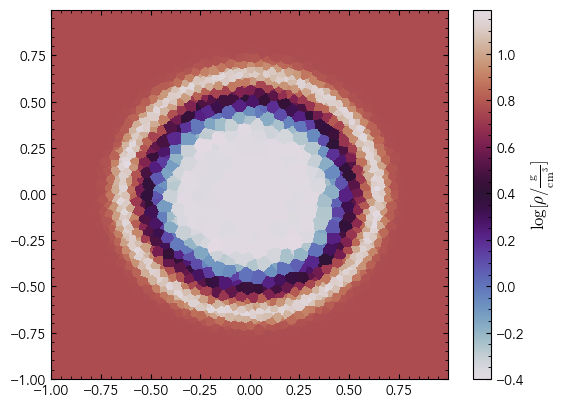

In [5]:
ax, im, data = snap.plots.peek()
plt.show()

### The first condition

In [6]:
# First condition
condition1 = snap.divV < 0

In [7]:
rho = snap.density
rho_shocked = np.where(condition1, rho, 0*rho)

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


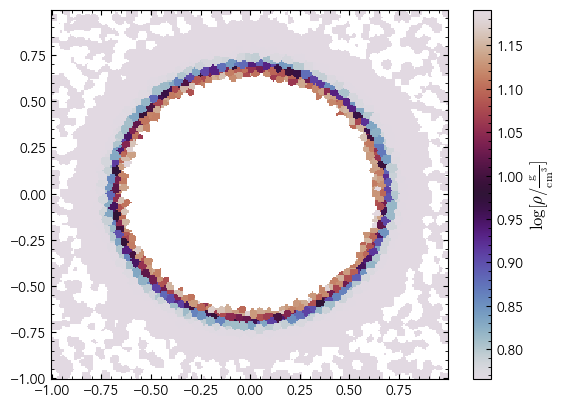

In [8]:
ax, im, sliced_rho = snap.plots.slice(rho_shocked, res=256)
plt.show()

### The second condition
$$
\begin{gather}
T = \frac{\mu m_H}{k_B} \frac{P}{\rho},\\
\partial^i T = \frac{\mu m_H}{k_B} [(\partial^iP)/\rho - P (\partial^i \rho) /\rho^2].
\end{gather}
$$

In [9]:
grad_P = np.stack([snap.DpDx, snap.DpDy, snap.DpDz], axis=-1)
grad_rho = np.stack([snap.DrhoDx, snap.DrhoDy, snap.DrhoDz], axis=-1)
P = snap.P
rho = snap.rho
T = u.mh / u.kb * P / rho # If the code has temperature output, do snap.Temperature

In [10]:
# numpy only broadcasts if we have matching trailing index (e.g., shape (3,10,)
# + shape (10,) works, but (10,3,) + shape (10,), which is what we have here,
# doesn't). So we transpose to (3,10,) to make it work and transpose back to 
# (10,3,) in the end.
grad_T = u.mh / u.kb * (grad_P.T / rho - P * grad_rho.T / rho**2).T

In [11]:
# The second condition
condition2 = np.vecdot(grad_T, grad_P) > 0
np.shape(condition2)

(100000,)

In [12]:
np.sum(condition2) # most of it is true

np.int64(92404)

In [13]:
rho_shocked = np.where(condition1 & condition2, rho, 0*rho)

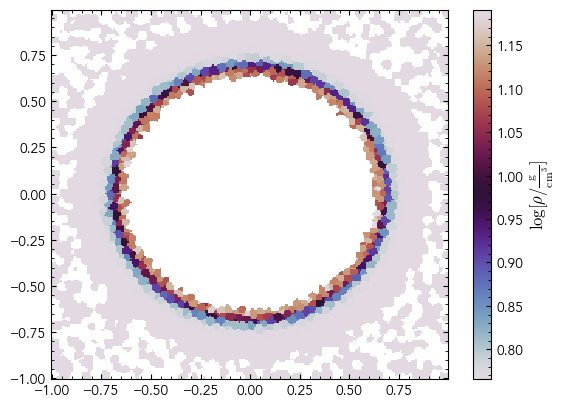

In [14]:
ax, im, sliced_rho = snap.plots.slice(rho_shocked, res=256)
plt.show()

### The third condition

In [31]:
def shock_direction(grad_T):
    """Find the shock direction given temperature gradient.
    d_s = - grad_T / |grad_T|
    """
    norm_grad_T = np.linalg.norm(grad_T, axis=-1, keepdims=True)

    # For small magnitudes, set ds to zero
    ds = - grad_T / norm_grad_T

    if len(np.shape(ds)) > 1:
        ds[norm_grad_T[:,0] < 1e-3 * norm_grad_T.units] = 0
    else:
        if norm_grad_T < 1e-3 * norm_grad_T.units:
            ds *= 0
    # ds = np.where(norm_grad_T < 1e-3, np.zeros_like(grad_T), - grad_T / norm_grad_T)

    return ds

In [ ]:
def next_cell_along_ds(kdtree, X, Y, Z, point, ds, step):
    """Find the previous/next point along the shock direction by moving in
    the shock direction by steps of distance `step` each time. Use a negative
    step for the opposite direction.
    """
    ds /= np.linalg.norm(ds, keepdims=True) # normalise ds just to be safe
        
    k = 0           # number of steps
    distance = 0    # distance between point and new_point
    while distance == 0:
        k += 1
        new_point = point + k * step * ds
        d, i  = kdtree.query(new_point)
        new_point = np.array([X[i], Y[i], Z[i]])
        distance = math.dist(point, new_point)

    return i

In [17]:
dev.MT2T1(M=1.3, gamma=5/3), dev.MP2P1(M=1.3, gamma=5/3)

(1.2921782544378697, 1.8624999999999998)

In [18]:
np.log10(dev.MT2T1(M=1.3, gamma=5/3)), np.log10(dev.MP2P1(M=1.3, gamma=5/3))

(np.float64(0.11132242819377774), np.float64(0.27009628142033043))

In [19]:
from scipy.spatial import KDTree
X = snap.X
Y = snap.Y
Z = snap.Z
coords = np.stack([X, Y, Z], axis=-1)
kdtree = KDTree(coords) # build tree

i_all = np.arange(len(snap))
i_shock_zone = i_all[condition1 & condition2]
condition3 = np.full(np.shape(i_all), False)


for idx in i_shock_zone:        # do only for cells already satisfying cond1 and 2, to save cost
    ds = shock_direction(grad_T[idx])
    step = 0.8 * np.cbrt(snap.volume[idx])
    point = coords[idx]
    
    if np.linalg.norm(ds) > 0 * u.Dimensionless:
        i_pre = next_cell_along_ds(kdtree, X, Y, Z, point, ds, step)
        i_post = next_cell_along_ds(kdtree, X, Y, Z, point, ds, -step)

        T_pre = T[i_pre]
        T_post = T[i_post]
        DlogT = np.log10(T_post) - np.log10(T_pre)
        # print(DlogT)

        P_pre = P[i_pre]
        P_post = P[i_post]
        DlogP = np.log10(P_post) - np.log10(P_pre)
        # print(DlogP)

        if (DlogT >= 0.11) & (DlogP >= 0.27):
            condition3[idx] = True

In [20]:
np.sum(condition3)

np.int64(17248)

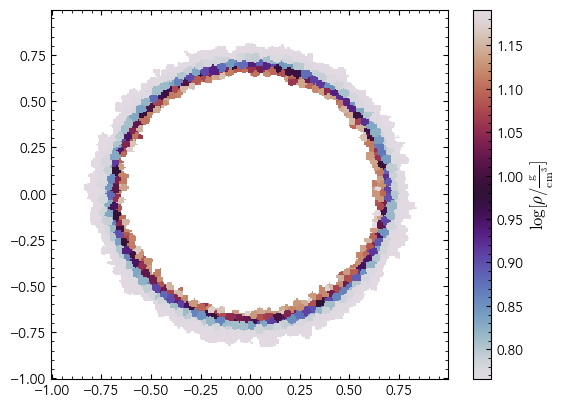

In [21]:
rho_shocked = np.where(condition1 & condition2 & condition3, snap.rho, 0*richio.units.system["density"]) # hmm just to look nice, in fact condition3 alone is enough...
ax, im, sliced_rho = snap.plots.slice(rho_shocked, res=256)
plt.show()

## Step 2: shock surface
This involves a "ray tracing" step

In [22]:
def T2T1M(T2_T1, gamma):
    """ Find mach number from the temperature jump (T2_T1). """
    a = 2 * gamma * (gamma - 1)
    minusb = gamma * 2 - 6 * gamma + T2_T1 * (gamma + 1)**2 + 1
    M2 = (minusb + np.sqrt(minusb**2 + 8 * a * (gamma - 1))) / (2 * a)
    return np.sqrt(M2)

def P2P1M(P2_P1, gamma):
    """ Find mach number from the pressure jump (P2_P1). """
    M2 = (P2_P1 * (gamma + 1) + gamma - 1) / (2 * gamma)
    return np.sqrt(M2)

def rho2rho1M(rho2_rho1, gamma):
    """ Find mach number from the density jump (rho2_rho1). """
    M2 = 2 * rho2_rho1 / (gamma + 1 - rho2_rho1 * (gamma - 1))
    return np.sqrt(M2)

In [ ]:
def ray_tracer(kdtree, X, Y, Z, shock_mask, x_shock, y_shock, z_shock, 
               idx_shock, idx_cell, divV_shock, ds_shock, direction, gamma=5/3):
    """Trace along shock direction until exiting shock zone.
    
    Parameters
    -----------
    kdtree : scipy.spatial.KDTree
        KDTree of all simulation cells.
    X, Y, Z : arrays
        All cell center coordinates.
    shock_mask : bool array
        Boolean mask of shock cells.
    x_shock, y_shock, z_shock : arrays
        Shock zone cell coordinates.
    idx_shock : array
        Global indices of shock zone cells.
    idx_cell : int
        Index within shock zone array.
    divV_shock : array
        Divergence field in shock zone.
    ds_shock : array
        Shock direction field in shock zone.
    direction : str
        'pre' or 'post' shock region.
    gamma : float
        Adiabatic index.
    
    Returns
    -----------
    i_final : int or False
        Global index of pre/post-shock cell, or False if ray rejected.
    """
    x_pt = x_shock[idx_cell]
    y_pt = y_shock[idx_cell]
    z_pt = z_shock[idx_cell]
    point = np.array([x_pt, y_pt, z_pt])
    
    divV_pt = divV_shock[idx_cell]
    ds_pt = np.array(ds_shock[idx_cell])
    
    # Estimate step size from nearest neighbors # TODO: use volume
    distances, _ = kdtree.query(point, k=10)
    step_size = np.median(distances[1:])  # exclude self
    
    # Ray trace until exiting shock zone
    in_shock = True
    step_sign = -1 if direction == 'post' else 1
    
    while in_shock:
        i_tree = next_cell_along_ds(kdtree, X, Y, Z, point, ds_pt, step_sign * step_size)
        in_shock = shock_mask[i_tree]
        
        if in_shock:
            # Find this cell in shock zone array
            idx_in_shock = np.argmin(np.abs(i_tree - idx_shock))
            divV_next = divV_shock[idx_in_shock]
            ds_next = ds_shock[idx_in_shock]
            
            # Reject if divergence decreases (unphysical ray)
            if divV_next < divV_pt:
                return False
            
            # Stop if shock direction reverses
            if np.dot(ds_pt, ds_next) < 0:
                in_shock = False
        
        point = np.array([X[i_tree], Y[i_tree], Z[i_tree]])
    
    return i_tree

def find_shock_surface(kdtree, X, Y, Z, T, P, rho, shock_mask, 
                       x_shock, y_shock, z_shock, idx_shock, divV_shock, ds_shock, gamma=5/3):
    """Find shock surface cells and their pre/post-shock counterparts.
    
    Parameters
    -----------
    kdtree : scipy.spatial.KDTree
        KDTree of all cells.
    X, Y, Z : arrays
        Cell coordinates.
    T, P, rho : arrays
        Temperature, pressure, density fields.
    shock_mask : bool array
        Shock zone mask.
    x_shock, y_shock, z_shock : arrays
        Shock zone coordinates.
    idx_shock : array
        Global indices of shock cells.
    divV_shock : array
        Divergence in shock zone.
    ds_shock : array
        Shock direction in shock zone.
    gamma : float
        Adiabatic index.
    
    Returns
    -----------
    M_T, M_P, M_rho : arrays
        Mach numbers from T, P, rho jumps.
    idx_surf : array
        Indices of surface cells (in shock zone array).
    idx_pre, idx_post : arrays
        Global indices of pre/post-shock cells.
    """
    M_T = []
    M_P = []
    M_rho = []
    idx_surf = []
    idx_pre = []
    idx_post = []
    
    for i in range(len(x_shock)):
        # x_pt, y_pt, z_pt = x_shock[i], y_shock[i], z_shock[i]
        # # Spatial domain restrictions (adjust as needed)
        # if x_pt < 7 or x_pt > 20 or np.abs(y_pt) > 25 or np.abs(z_pt) > 1:
        #     continue
        
        if np.linalg.norm(ds_shock[i]) == 0:
            continue
        
        # Ray trace to post-shock
        i_post = ray_tracer(kdtree, X, Y, Z, shock_mask, x_shock, y_shock, z_shock,
                            idx_shock, i, divV_shock, ds_shock, direction='post', gamma=gamma)
        if i_post is False:
            continue
        
        T_post = T[i_post]
        
        # Ray trace to pre-shock
        i_pre = ray_tracer(kdtree, X, Y, Z, shock_mask, x_shock, y_shock, z_shock,
                           idx_shock, i, divV_shock, ds_shock, direction='pre', gamma=gamma)
        if i_pre is False:
            continue
        
        T_pre = T[i_pre]
        T_jump = T_post / T_pre
        
        # Only accept if temperature increases (physical shock)
        if T_jump < 1:
            continue
        
        # Record surface cell
        idx_surf.append(i)
        idx_pre.append(i_pre)
        idx_post.append(i_post)
        
        # Calculate Mach numbers from jumps
        P_pre, P_post = P[i_pre], P[i_post]
        P_jump = P_post / P_pre
        
        rho_pre, rho_post = rho[i_pre], rho[i_post]
        rho_jump = rho_post / rho_pre
        
        M_T.append(T2T1M(T_jump, gamma))
        M_P.append(P2P1M(P_jump, gamma))
        M_rho.append(rho2rho1M(rho_jump, gamma))
    
    return np.array(M_T), np.array(M_P), np.array(M_rho), \
        np.array(idx_surf), np.array(idx_pre), np.array(idx_post)

In [34]:
# Step 2: Find shock surface
# ...existing code...

# Build KDTree for efficient nearest-neighbor queries
coords = np.stack([X, Y, Z], axis=-1)
kdtree = KDTree(coords)

# Prepare shock zone data
i_shock = i_all[condition1 & condition2 & condition3]
x_shock = X[i_shock]
y_shock = Y[i_shock]
z_shock = Z[i_shock]
divV_shock = snap.divV[i_shock]
ds_shock = shock_direction(grad_T[i_shock])

# Find shock surface
M_T, M_P, M_rho, idx_surf, idx_pre, idx_post = find_shock_surface(
    kdtree, X, Y, Z, T, snap.P, snap.rho, 
    condition1 & condition2 & condition3,
    x_shock, y_shock, z_shock, i_shock, divV_shock, ds_shock,
    gamma=5/3
)

print(f"Found {len(idx_surf)} shock surface cells")
print(f"Mach numbers - T: {M_T.mean():.2f}, P: {M_P.mean():.2f}, rho: {M_rho.mean():.2f}")

Found 4788 shock surface cells
Mach numbers - T: 219.08, P: 145.41, rho: 1.60


In [42]:
i_shock_surface_orig = i_shock[idx_surf] # convert index of shockzone to index of all

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


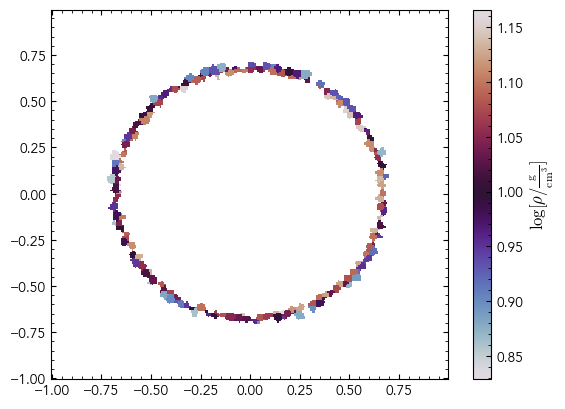

In [43]:
rho_shocked = np.zeros_like(snap.rho)
rho_shocked[i_shock_surface_orig] = snap.rho[i_shock_surface_orig]
ax, im, sliced_rho = snap.plots.slice(rho_shocked, res=256)
plt.show()